In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt

import scipy_extra.fit
import scipy_extra.stats
import scipy_extra.plot

# Simple Fit

## Distribution
At first you have to define a scipy distribution which you want to fit to your data
A good starting point is the rv_mixture distribution which offers you the possibility to define a mixture of several other scipy.stats distributions

In [2]:
continuum_hist = np.histogram(scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5), bins=20)
distribution = scipy_extra.stats.rv_mixture([('signal', scipy.stats.norm),
                                             ('background', scipy.stats.norm),
                                             ('continuum', scipy.stats.rv_histogram(continuum_hist))])

## Mapping
Secondly you need to define a mapping from the free parameters in the fit to the shape parameters of your distribution. In this way you can incorporate arbitrary constraints in your model.

In [3]:
def mapping(free_parameters):
    return dict(signal_loc=free_parameters[0],
                signal_scale=0.5,
                signal_norm=free_parameters[1],
                background_loc=free_parameters[2],
                background_scale=1.0,
                background_norm=free_parameters[3],
                continuum_loc=0.0,
                continuum_scale=1.0,
                continuum_norm=free_parameters[4])

## Normalisation
Finally you can define a normalisation function which returns the overall norm of your distribution given the shape parameters. If you don't define this, one is assumed and your overall normalisation will be probably off.

In [4]:
def normalisation(parameters):
        return parameters['signal_norm'] + parameters['background_norm'] + parameters['continuum_norm']

## Fitter

In [5]:
fitter = scipy_extra.fit.Fitter(mapping, distribution, normalisation=normalisation)

The true parameters of our model (unknown in a real world example!)

In [6]:
true_parameters = [0.4, 0.2, 0.6, 0.6, 0.2]

We generate some fake data using these true parameters.

In [7]:
expected_number_of_events = 1000
data = distribution.rvs(size=np.random.poisson(expected_number_of_events), **mapping(true_parameters))

And now we fit the fake data using a initial guess for the parameters (different from the true parameters!)
We perform an extended ML fit by providing the expected number of events in addition to the measured data

In [8]:
initial_parameters = [0.1, 0.1, 0.6, 0.3, 0.6]
r = fitter.fit(initial_parameters, data, expected_number_of_events=expected_number_of_events)
r

 final_simplex: (array([[0.27038014, 0.19722084, 0.54112332, 0.65795643, 0.10981078],
       [0.27028768, 0.19719921, 0.54113471, 0.6579888 , 0.10981097],
       [0.27032079, 0.19725094, 0.54115222, 0.65788356, 0.10983549],
       [0.27032834, 0.19720183, 0.54107792, 0.65796269, 0.10981268],
       [0.27030057, 0.19724088, 0.54108107, 0.65796684, 0.10980509],
       [0.27030054, 0.1972453 , 0.54112261, 0.6579521 , 0.1097822 ]]), array([-4287.07587021, -4287.07587004, -4287.07586974, -4287.07586968,
       -4287.07586952, -4287.07586949]))
           fun: -4287.0758702114435
       message: 'Optimization terminated successfully.'
          nfev: 442
           nit: 276
        status: 0
       success: True
             x: array([0.27038014, 0.19722084, 0.54112332, 0.65795643, 0.10981078])

## Uncertainty and Significance
After fitting we can get the uncertainty from the likelihood profile.
You have to pass the boundaries of all parameters you want the uncertainty for,
here we are only interested in the normalisations, so we pass None for the boundary of the location parameters.

In [9]:
uncertainties = fitter.get_uncertainties([None, [0.0, 1.0], None, [0.0, 1.0], [0.0, 1.0]], data, 
                                         expected_number_of_events=expected_number_of_events)
uncertainties

[[None, None],
 [0.14586325434098066, 0.2499217753498492],
 [None, None],
 [0.5759369348665939, 0.7379819794796485],
 [0.07260052031293458, 0.15114902405719727]]

In a similar way we can obtain the significance of the fit with respect to a null hypothesis.
Here we set the signal_norm to 0 and leave all other parameters free in the fit.

In [10]:
significance = fitter.get_significance([None, 0.0, None, None, None, None], data,
                                       expected_number_of_events=expected_number_of_events)
significance

3.936956964495986

We can also directly calculate the likelihood profile

In [11]:
profile_values = [None, np.linspace(0, 1, 21), None, None, None]
likelihood_profile = fitter.likelihood_profile(profile_values, data, expected_number_of_events=expected_number_of_events)
likelihood_profile

array([-4279.32605514, -4282.82063422, -4285.251634  , -4286.65390311,
       -4287.07445055, -4286.57440705, -4285.22950026, -4283.12451559,
       -4280.33387491, -4276.883638  , -4272.70876458, -4267.64324428,
       -4261.47135556, -4254.00794713, -4245.14371652, -4234.8421597 ,
       -4223.11697402, -4210.01113858, -4195.58282564, -4179.89689673,
       -4163.02002382])

## Plotting 
There are some pre-defined plotting routines available.
I recommend to copy the plotting code and adapt it to your requirements (naturally there are a lot of things you might want to change)

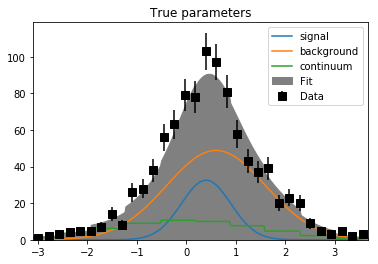

In [12]:
plt.title("True parameters")
scipy_extra.plot.fit(fitter, data, free_parameters=true_parameters)

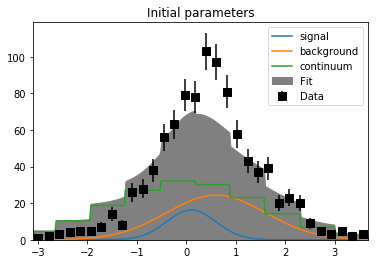

In [13]:
plt.title("Initial parameters")
scipy_extra.plot.fit(fitter, data, free_parameters=initial_parameters)

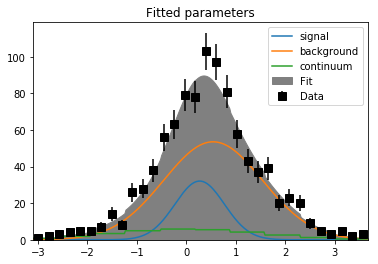

In [14]:
plt.title("Fitted parameters")
scipy_extra.plot.fit(fitter, data)

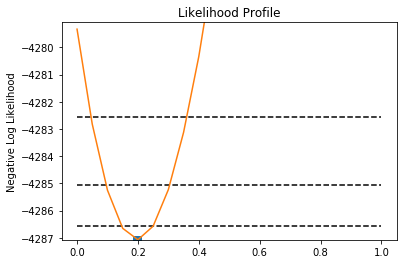

In [15]:
plt.title("Likelihood Profile")
scipy_extra.plot.likelihood_profile(fitter, profile_values, likelihood_profile, 1)

## Toy Experiments
Finally we can do some toy experiments
For example to estimate the stability of the fit we perform the fit multiple times with different signal norm values

In [16]:
toy_stability_parameters = [[true_parameters[0], x, true_parameters[2], (1-x)*0.75, (1-x)*0.25] for x in np.repeat(np.linspace(0, 0.5, 11), 20)]
toy_stability_results = fitter.toy(initial_parameters, toy_stability_parameters, 1000)

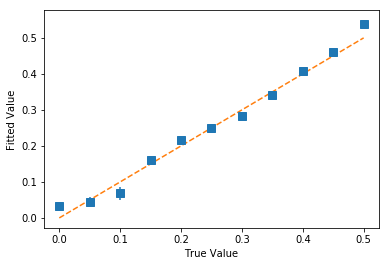

In [17]:
scipy_extra.plot.stability(fitter, toy_stability_results, 1)

Or we can calculate the pull distribution for our fit by performing the fit several times using the same parameters
This will take some time, because for the pull we have to calculate the uncertainty of each toy experiment.

In [18]:
toy_pull_parameters = [true_parameters]*100
toy_pull_results = fitter.toy(initial_parameters, toy_pull_parameters, 1000, [None, [0.0, 1.0], None, None, None])

Could not find a valid lower boundary. Setting lower boundary to the given boundary.
Could not find a valid lower boundary. Setting lower boundary to the given boundary.


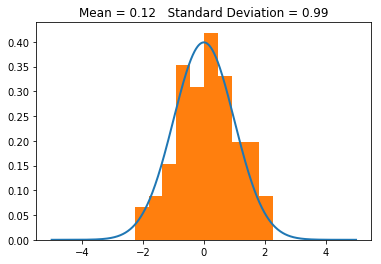

In [19]:
scipy_extra.plot.pull(fitter, toy_pull_results, 1)

# Binned Fit
By providing a binning, the Fitter class can also perform a binned ML fit.
The data is still supposed to be provided in unbinned form, and is binned internally.

In [20]:
fitter = scipy_extra.fit.Fitter(mapping, distribution, binnings=dict(bins=20, range=(-5,5)), normalisation=normalisation)

In [21]:
initial_parameters = [0.1, 0.1, 0.6, 0.3, 0.6]
r = fitter.fit(initial_parameters, data, expected_number_of_events=expected_number_of_events)
r

 final_simplex: (array([[0.27702474, 0.22738362, 0.57466947, 0.5997526 , 0.13800368],
       [0.2770222 , 0.22731441, 0.57459191, 0.5998268 , 0.13799207],
       [0.27702373, 0.22738977, 0.5747084 , 0.59969549, 0.1380669 ],
       [0.27696472, 0.22733059, 0.57458092, 0.59982096, 0.13800393],
       [0.27698369, 0.22736823, 0.57466853, 0.59971433, 0.13804159],
       [0.27707081, 0.22737818, 0.57463845, 0.59971243, 0.13802753]]), array([-3604.16635117, -3604.16635078, -3604.16635055, -3604.16635024,
       -3604.16635005, -3604.16634972]))
           fun: -3604.166351165078
       message: 'Optimization terminated successfully.'
          nfev: 395
           nit: 250
        status: 0
       success: True
             x: array([0.27702474, 0.22738362, 0.57466947, 0.5997526 , 0.13800368])

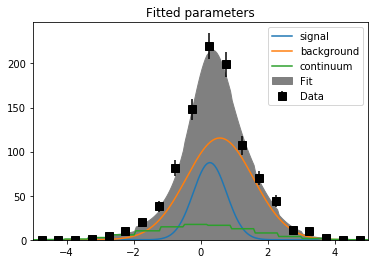

In [22]:
plt.title("Fitted parameters")
scipy_extra.plot.fit(fitter, data, binning=dict(bins=20, range=(-5,5)))

In [23]:
uncertainties = fitter.get_uncertainties([None, [0.0, 1.0], None, [0.0, 1.0], [0.0, 1.0]], data,
                                         expected_number_of_events=expected_number_of_events)
uncertainties

[[None, None],
 [0.17186552631302413, 0.28470405556855105],
 [None, None],
 [0.5091535247992627, 0.6883482310202056],
 [0.09540598876223907, 0.18426763752911998]]

In [24]:
significance = fitter.get_significance([None, 0.0, None, None, None, None], data,
                                       expected_number_of_events=expected_number_of_events)
significance

4.236160644751423

In [25]:
profile_values = [None, np.linspace(0, 1, 21), None, None, None]
likelihood_profile = fitter.likelihood_profile(profile_values, data, expected_number_of_events=expected_number_of_events)

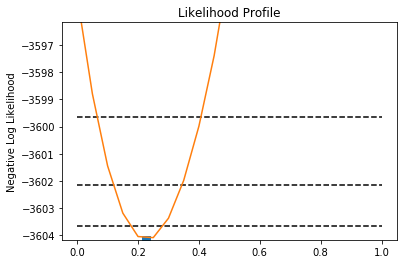

In [26]:
plt.title("Likelihood Profile")
scipy_extra.plot.likelihood_profile(fitter, profile_values, likelihood_profile, 1)

In [27]:
toy_stability_parameters = [[true_parameters[0], x, true_parameters[2], (1-x)*0.75, (1-x)*0.25] for x in np.repeat(np.linspace(0, 0.5, 11), 20)]
toy_stability_results = fitter.toy(initial_parameters, toy_stability_parameters, 1000)

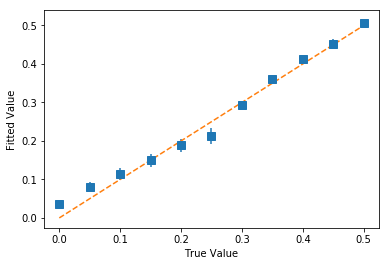

In [28]:
scipy_extra.plot.stability(fitter, toy_stability_results, 1)

In [29]:
toy_pull_parameters = [true_parameters]*100
toy_pull_results = fitter.toy(initial_parameters, toy_pull_parameters, 1000, [None, [0.0, 1.0], None, None, None])

Could not find a valid lower boundary. Setting lower boundary to the given boundary.
Could not find a valid lower boundary. Setting lower boundary to the given boundary.
Could not find a valid lower boundary. Setting lower boundary to the given boundary.


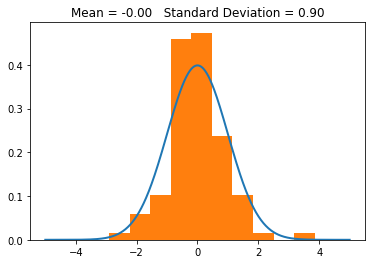

In [30]:
scipy_extra.plot.pull(fitter, toy_pull_results, 1)

# Simultaneous Fit
You can fit multiple channels simultaneously by providing multiple distributions as a list.
The mapping must return a list of dictionaries in this case, so one dictionary with shape parameters for each of the distributions

In [31]:
# TODO